<a href="https://colab.research.google.com/github/vitorbeltrao/NLP_Spam_Classifier/blob/main/Classificador_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processamento de Linguagem Natural - Classificador Spam

O texto está em todos os lugares. Muitos aplicativos ainda produzem ou registram texto. Registros médicos, registros de reclamação do consumidor, dúvidas sobre produtos e muitos outros exemplos ainda são destinados, principalmente, a comunicação entre pessoas, e não computadores, por isso, ainda são "codificados" como texto. **Explorar essa vasta quantidade de dados requer sua conversão em uma forma significativa.**


<center><img src="https://image.freepik.com/free-vector/natural-language-processing-illustration_23-2149223763.jpg" height="300"></center>

**Processamento de Linguagem Natural ou PLN é um ramo da Inteligência Artificial que lida com a ponte entre os seres humanos e as máquinas, para que essas possam entender a nossa linguagem.**

O texto costuma ser chamado de dados "não estruturados". Isso se refere ao fato de que o texto não tem o tipo de estrutura que normalmente esperamos dos dados: tabelas de registros com significados fixos, bem como ligações entre as tabelas.

Aqui, vamos analisar apenas um problema básico dessa área, as classificações de mensagens. Vamos aos detalhes!




## Panorama geral

**Neste projeto, iremos criar um classificador spam**. Vamos supor que uma empresa nos tenha procurado para fazer esse trabalho. Eles nos passaram um conjunto de dados de mensagens de texto que foram coletadas por eles ao longo do tempo. Esse conjunto de dados, contém mensagens em inglês e todas elas estão marcadas como ham (legítimo) ou spam.

**O objetivo do negócio será: criar um modelo que irá classificar as mensagens como spam ou não spam.**

<center><img src="https://image.freepik.com/free-vector/businessmen-get-advertising-phishing-spreading-malware-irrelevant-unsolicited-spam-message-spam-unsolicited-messages-malware-spreading-concept_335657-1837.jpg" height="300"></center>

A nossa solução será de grande ajuda para a empresa, pois, com o modelo classificador em mãos eles poderão diminuir a mão de obra destinada a fazer essa tarefa quase manualmente, já que, o modelo que eles possuem atualmente não é muito melhor que um simples "chute". **Isso certamente os ajudará a diminuir os custos!**

Essa é uma típica tarefa de **classificação**, portanto, iremos utilizar modelos capazes de fazer essa tarefa.

Tecnicamente, iremos abordar este problema de forma **supervisionada** já que o nosso conjunto de dados possui uma coluna rotulando as mensagens e será um aprendizado **offline** (ou em batch) **baseado em modelo**.





### Medidas de desempenho

Iremos medir o desempenho do modelo com a **matriz de confusão**. Além dela, iremos utilizar também uma métrica mais concisa que é a **precisão**, já que, não queremos de forma alguma que uma mensagem que não é spam seja classificada como spam. Essa é a premissa principal. 

A empresa nos pediu um classificador com pelo menos 90% de precisão. Mas é claro que o **recall** também tem que ser bom. **Um classificador de alta precisão não é lá muito útil se o recall for muito baixo!**

## Coleta dos dados

Os dados desse projeto foram extraídos do [Kaggle](https://www.kaggle.com/).

Em ambientes tradicionais, os dados estariam disponíveis em um banco de dados relacional (ou em algum outro data store) e distribuídos por várias tabelas/documentos/arquivos. Neste projeto as coisas são bem mais simples: Vamos fazer o download dos dados que estão em um formato csv e transformá-los em um dataframe pandas para começar a trabalhar!

In [1]:
# Importar os pacotes necessários.
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

import sklearn.metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Código que transforma o csv em um dataframe pandas
df = pd.read_csv("https://raw.githubusercontent.com/vitorbeltrao/NLP_Spam_Classifier/main/data/spam.csv", encoding="ISO-8859-1")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Uma rápida olhada na estrutura dos dados

Antes de separar o conjunto em treino e teste, vamos verificar sua estrutura.

* Verificar as 5 primeiras entradas

In [2]:
# Verificar as 5 primeiras entradas
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Cada linha desse conjunto de dados representa uma mensagem de texto (coluna v2) junto ao seu rótulo (coluna v1). As colunas restantes não parecem ser muito usuais, vamos investigar.

* Verificar o tamanho, tipo e valores nulos dos dados

In [3]:
# Verificar o tamanho, tipo e valores nulos dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


O conjunto de dados possui 5572 entradas e 5 colunas. Como ja desconfiávamos, as colunas com nome "Unamed:" possuem uma grande quantidade de valores nulos, o que certamente não será de grande ajuda para nós.

* Verificar a porcentagem de valores nulos

In [4]:
# Verificar a porcentagem de valores nulos
df.isnull().sum() / df.shape[0]

v1            0.000000
v2            0.000000
Unnamed: 2    0.991027
Unnamed: 3    0.997846
Unnamed: 4    0.998923
dtype: float64

Como imaginamos! As colunas "Unamed:" possuem quase 100% das suas entradas nulas, isso é impraticável. Em etapas posteriores iremos apagar essas colunas.

### Criar um conjunto de testes

Para evitarmos o overfitting, vamos separar o conjunto de treino e testes aqui.

In [5]:
# Separando o conjunto de dados em treino e teste
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)
train_set_size = len(train_set)
test_set_size = len(test_set)

print('Tamanho do conjunto de treino:', train_set_size)
print('Tamanho do conjunto de teste:', test_set_size)

Tamanho do conjunto de treino: 4457
Tamanho do conjunto de teste: 1115


## Análise exploratória

Até o momento, você teve um pequeno vislumbre de como as coisas funcionam para entender o conjunto de dados que você está manipulando. Agora o objetivo é aprofundar um pouco mais.

**Vamos explorar mais a fundo todo o conjunto de dados de treino.**

Em primeiro lugar, havíamos definido que apagaríamos as colunas "Unamed:", portanto, vamos fazer isso e renomear as colunas que iremos utilizar.

* Apagar as colunas "Unamed:" e renomear as colunas do conjunto de dados

In [6]:
# Criar uma cópia dos dados de treino
df_eda = train_set.copy()

# Excluir as colunas "Unamed:"
df_eda.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], 
             axis = 1, inplace = True)

# Renomear as colunas que iremos utilizar
df_eda.rename(columns={'v1': 'target'}, inplace = True)
df_eda.rename(columns={'v2': 'sms'}, inplace = True)

# Verificar as 5 primeiras entradas
df_eda.head()

,target,sms
1978,ham,No I'm in the same boat. Still here at my moms...
3989,spam,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3935,ham,They r giving a second chance to rahul dengra.
4078,ham,O i played smash bros &lt;#&gt; religiously.
4086,spam,PRIVATE! Your 2003 Account Statement for 07973...


Temos agora um conjunto de dados mais limpo para explorar e trabalhar.

* Verificar o balanceamento da variável alvo

ham     3860
spam     597
Name: target, dtype: int64


[]

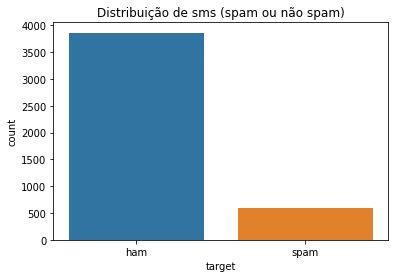

In [7]:
# Balanceamento da variável alvo
print(df_eda.target.value_counts())
fig, ax = plt.subplots()
sns.countplot('target', data=df_eda, ax=ax)
ax.set_title('Distribuição de sms (spam ou não spam)')
plt.plot()

Temos um conjunto de dados desbalanceado. Note que possuímos muitos valores da classe "ham" e poucos valores da classe "spam", isso pode prejudicar o desempenho do modelo, pois, ele pode ficar muito bom em prever a classe com mais exemplos mas não tão bom assim na classe com poucos exemplos e esse não é o objetivo, precisamos do equilíbrio.

Nesse caso, iremos utilizar uma métrica de avaliação que é o F1-score, ele é basicamente uma média harmônica entre a precisão e o recall e favorece os classificadores que tem essas duas métricas com desempenho semelhante, prevalecendo, o equilíbrio.

Para finalizar essa análise exploratória, uma forma muito legal de explorar esse tipo de problema, é criar um gráfico do tipo "word cloud" ou "nuvem de palavras", dessa forma teremos uma visualização interessante das palavras que mais ocorrem nos respectivos rótulos.

* Word cloud dos rótulos "ham" e "spam"

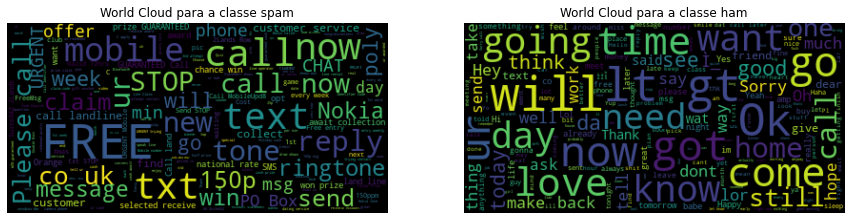

In [8]:
# Word cloud dos rótulos "ham" e "spam"
from wordcloud import WordCloud

string_spam = ' '.join([elem for elem in df_eda.query('target == "spam"').sms.tolist()])
string_ham = ' '.join([elem for elem in df_eda.query('target == "ham"').sms.tolist()])

wordcloud_spam = WordCloud(max_font_size=50).generate(string_spam)
wordcloud_ham = WordCloud(max_font_size=50).generate(string_ham)

f, axs = plt.subplots(2,2,figsize=(15,15)) 
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.title("World Cloud para a classe spam")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis("off")
plt.title("World Cloud para a classe ham")

plt.show()

Veja que padrão interessante. Algumas das palavras mais frequentes nos textos da classe spam são: "Free", "Win", "Call now", "Please call", "Urgent", entre outras. Essas palavras realmente são bem típicas de spams.

Já as palavras nos textos da classe ham são menos apelativas.

## Feature Engineering

Antes de começar a limpeza e a preparação dos dados, vamos fazer um feature engineering, para criar novas variáveis, explorar ainda mais o conjunto de dados e possivelmente melhorar a capacidade de previsão do modelo de machine learning.

***

* Verificar o número de caracteres, palavras e sentenças em cada mensagem

In [9]:
# Criar uma cópia do conjunto de dados
df_prep = df_eda.copy()

# Adicionando uma coluna de números de caracteres, palavras e frases em cada mensagem
df_prep["no_caracteres"] = df_prep["sms"].apply(len)
df_prep["no_palavras"]=df_prep.apply(lambda row: nltk.word_tokenize(row["sms"]), axis=1).apply(len)
df_prep["no_sentencas"]=df_prep.apply(lambda row: nltk.sent_tokenize(row["sms"]), axis=1).apply(len)
# Nesta etapa, "tokenizamos" as palavras e frases usando o comprimento das mesmas.

# 5 primeiras entradas
df_prep.head()

,target,sms,no_caracteres,no_palavras,no_sentencas
1978,ham,No I'm in the same boat. Still here at my moms...,83,25,4
3989,spam,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,137,26,1
3935,ham,They r giving a second chance to rahul dengra.,46,10,1
4078,ham,O i played smash bros &lt;#&gt; religiously.,46,14,1
4086,spam,PRIVATE! Your 2003 Account Statement for 07973...,148,24,3


Vejam as novas colunas criadas, bem interessante né? Vamos explorá-las um pouco.

* Resumo estatístico do dataframe das mensagens de não spam

In [10]:
# Resumo estatístico de ham
df_prep_ham = df_prep.loc[(df_prep['target'] == 'ham')]
df_prep_ham.describe().T

,count,mean,std,min,25%,50%,75%,max
no_caracteres,3860.0,70.588342,55.674169,2.0,33.0,52.0,91.25,632.0
no_palavras,3860.0,17.011658,13.504028,1.0,8.0,13.0,22.00,219.0
no_sentencas,3860.0,1.834197,1.453065,1.0,1.0,1.0,2.00,38.0


* Resumo estatístico do dataframe das mensagens de spam

In [11]:
# Resumo estatístico de spam
df_prep_spam = df_prep.loc[(df_prep['target'] == 'spam')]
df_prep_spam.describe().T

,count,mean,std,min,25%,50%,75%,max
no_caracteres,597.0,139.206030,29.024974,25.0,134.0,150.0,158.0,224.0
no_palavras,597.0,27.780570,6.619609,5.0,25.0,29.0,32.0,44.0
no_sentencas,597.0,3.020101,1.503775,1.0,2.0,3.0,4.0,9.0


Nessas medidas estatísticas, notamos alguns padrões interessantes. **O primeiro** é que a média e a mediana do número de caracteres, palavras e sentenças da classe spam é consideralvelmente maior do que da classe não spam. **O segundo** é que, mesmo que a média e a mediana da classe não spam sejam menores, os valores máximos chegam a ser bem maiores, o que leva a crer que as mensagens da classe spam tem um certo "padrão" de tamanho de mensagem, diferente da classe não spam que podem ser mensagens desde um simples "ok" até mensagens enormes.

Vamos ver isso de uma forma gráfica.

* Histograma do número de palavras das respectivas classes

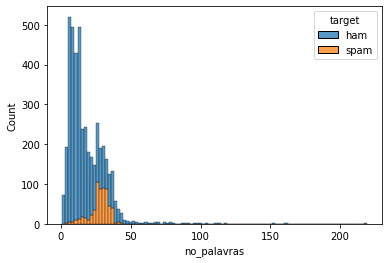

In [12]:
# Histograma 
sns.histplot(data = df_prep, x = 'no_palavras', 
             hue = 'target', multiple = 'stack')

Nessa visão gráfica fica mais claro o que acabamos de falar acima. Dá pra notar nesse histograma a presença de alguns poucos possíveis outliers, mas por enquanto, vamos deixar do jeito que está.

## Limpeza e preparação dos dados

Essa é uma parte crucial do projeto. Aqui iremos realizar diversos tratamentos que irão determinar diretamente o desempenho do algoritmo. Esses processos se desenvolvem mais ou menos assim:

<center><img src="https://github.com/vitorbeltrao/Pictures/blob/main/NLP.jpg?raw=true" height="300"></center>

Esse processo todo, consiste basicamente numa "limpeza geral" para que o algoritmo consiga entender e processar os textos de maneira correta, da forma que precisamos. Vale ressaltar, que não necessariamente você tem que aplicar todas essas transformações detalhadas acima, aqui iremos fazê-lo, mas fica a critério de cada um adotar o que é melhor para cada caso.

### 1 - Limpeza dos textos

Aqui faremos a remoção de pontuações, links, números e conversão dos caracteres para letra minúscula. Os algoritmos não distinguem esse tipo de coisa, portanto, eles apenas poluem, por isso vamos eliminar.


In [13]:
# Criar uma cópia do dataframe
df_clean = df_prep.copy()

# Limpeza dos textos
def clean_text(text):
    '''
        Função para colocar os textos em minúsculo, remover os textos entre
        colchetes, remover links, remover pontuações e remover palavras que
        contenham números
    '''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text) # Remove as urls
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove as pontuações
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [14]:
df_clean['sms_clean'] = df_clean['sms'].apply(clean_text)
df_clean.head()

,target,sms,no_caracteres,no_palavras,no_sentencas,sms_clean
1978,ham,No I'm in the same boat. Still here at my moms...,83,25,4,no im in the same boat still here at my moms c...
3989,spam,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,137,26,1,bank of granite issues strongbuy explosive pic...
3935,ham,They r giving a second chance to rahul dengra.,46,10,1,they r giving a second chance to rahul dengra
4078,ham,O i played smash bros &lt;#&gt; religiously.,46,14,1,o i played smash bros ltgt religiously
4086,spam,PRIVATE! Your 2003 Account Statement for 07973...,148,24,3,private your account statement for shows un...


Vejam a diferença do texto limpo com o texto original. Impressionante né?

### 2 - Tokenização

Normalmente, todo texto é considerado em conjunto e é recuperado como item individual quando combinado ou categorizado. **Um texto é composto por "tokens" ou "termos individuais".**

A tokenização é a quebra de dados grandes e complexos em unidades menores chamados "tokens". Isso pode ser feito dividindo os parágrafos em frases e as frases em palavras. **É basicamente uma segmentação de palavras.**



In [15]:
# Tokenização 
df_clean["sms_tokenized"] = df_clean.apply(lambda row: nltk.word_tokenize(row["sms_clean"]), axis=1)
df_clean.head()

,target,sms,no_caracteres,no_palavras,no_sentencas,sms_clean,sms_tokenized
1978,ham,No I'm in the same boat. Still here at my moms...,83,25,4,no im in the same boat still here at my moms c...,"[no, im, in, the, same, boat, still, here, at,..."
3989,spam,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,137,26,1,bank of granite issues strongbuy explosive pic...,"[bank, of, granite, issues, strongbuy, explosi..."
3935,ham,They r giving a second chance to rahul dengra.,46,10,1,they r giving a second chance to rahul dengra,"[they, r, giving, a, second, chance, to, rahul..."
4078,ham,O i played smash bros &lt;#&gt; religiously.,46,14,1,o i played smash bros ltgt religiously,"[o, i, played, smash, bros, ltgt, religiously]"
4086,spam,PRIVATE! Your 2003 Account Statement for 07973...,148,24,3,private your account statement for shows un...,"[private, your, account, statement, for, shows..."


### 3 - Remover as stopwords

Agora é a hora de remover as palavras que não tem muito o que acrescentar a nível de informação dos textos, como por exemplo os artigos em uma frase.

Uma stopword é uma palavra muito comum no idioma que está sendo analisada. As palavras "a", "e", "de" e "em" são consideradas stopwords e costumam ser removidas.

Essas stopwords, como costumam ser chamadas, também não agregam informação e podem reduzir o desempenho do algoritmo, por isso vamos elimina-las também.

In [16]:
# Remover as stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

df_clean["nostopword_sms"] = df_clean["sms_tokenized"].apply(remove_stopwords)
df_clean.head()

,target,sms,no_caracteres,no_palavras,no_sentencas,sms_clean,sms_tokenized,nostopword_sms
1978,ham,No I'm in the same boat. Still here at my moms...,83,25,4,no im in the same boat still here at my moms c...,"[no, im, in, the, same, boat, still, here, at,...","[im, boat, still, moms, check, yo, im, half, n..."
3989,spam,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,137,26,1,bank of granite issues strongbuy explosive pic...,"[bank, of, granite, issues, strongbuy, explosi...","[bank, granite, issues, strongbuy, explosive, ..."
3935,ham,They r giving a second chance to rahul dengra.,46,10,1,they r giving a second chance to rahul dengra,"[they, r, giving, a, second, chance, to, rahul...","[r, giving, second, chance, rahul, dengra]"
4078,ham,O i played smash bros &lt;#&gt; religiously.,46,14,1,o i played smash bros ltgt religiously,"[o, i, played, smash, bros, ltgt, religiously]","[played, smash, bros, ltgt, religiously]"
4086,spam,PRIVATE! Your 2003 Account Statement for 07973...,148,24,3,private your account statement for shows un...,"[private, your, account, statement, for, shows...","[private, account, statement, shows, unredeeme..."


### 4 - Stemização ou Lematização

O processo de **stemização** consiste em reduzir uma palavra ao seu radical. A palavra "meninas" se reduziria a "menin", assim como "meninos" e "menininhos". As palavras "gato", "gata", "gatos" e "gatas" reduziram-se para "gat".

Já a **lematização**, tem como objetivo reduzir uma palavra à sua forma base e agrupar diferentes formas da mesma palavra. Por exemplo, as palavras "correr", "corre" e "correu" são todas formas da palavra "correr", portanto "correr" é o lema de todas as palavras anteriores.

A vantagem de aplicar a stemização ou lematização é clara: redução de vocabulário e abstração de significado, para obtermos um melhor desempenho nos algoritmos.

**Aqui iremos seguir com a lematização, mas fique a vontade para utilizar a que você julgar mais adequada para o seu projeto.**



In [17]:
lemmatizer = WordNetLemmatizer()
# Lematização
def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

df_clean["lemmatized_sms"] = df_clean["nostopword_sms"].apply(lemmatize_word)
df_clean.head()

,target,sms,no_caracteres,no_palavras,no_sentencas,sms_clean,sms_tokenized,nostopword_sms,lemmatized_sms
1978,ham,No I'm in the same boat. Still here at my moms...,83,25,4,no im in the same boat still here at my moms c...,"[no, im, in, the, same, boat, still, here, at,...","[im, boat, still, moms, check, yo, im, half, n...","[im, boat, still, moms, check, yo, im, half, n..."
3989,spam,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,137,26,1,bank of granite issues strongbuy explosive pic...,"[bank, of, granite, issues, strongbuy, explosi...","[bank, granite, issues, strongbuy, explosive, ...","[bank, granite, issue, strongbuy, explosive, p..."
3935,ham,They r giving a second chance to rahul dengra.,46,10,1,they r giving a second chance to rahul dengra,"[they, r, giving, a, second, chance, to, rahul...","[r, giving, second, chance, rahul, dengra]","[r, give, second, chance, rahul, dengra]"
4078,ham,O i played smash bros &lt;#&gt; religiously.,46,14,1,o i played smash bros ltgt religiously,"[o, i, played, smash, bros, ltgt, religiously]","[played, smash, bros, ltgt, religiously]","[play, smash, bros, ltgt, religiously]"
4086,spam,PRIVATE! Your 2003 Account Statement for 07973...,148,24,3,private your account statement for shows un...,"[private, your, account, statement, for, shows...","[private, account, statement, shows, unredeeme...","[private, account, statement, show, unredeemed..."


Finalizada essa parte de limpeza geral. Falta apenas duas coisas para começarmos a treinar nossos algoritmos, criar uma matriz esparsa da lista de palavras lematizadas (ou stemizadas) e passar a coluna alvo (target) para numérica.

### 5 - Vetorização

Queremos converter nossa lista de palavras lematizadas para uma matriz, isso é necessário para que o algoritmo entenda o que estamos querendo passar.

Esse método, basicamente, cria valores para cada palavra em nossas mensagens de texto. Os valores são calculados de uma maneira que os pesos mais altos são atribuídos a palavras com menos frequência, ou seja, as palavras que menos ocorrem possuem um valor mais alto no fim das contas. Isso acontece para que as palavras que acontecem com mais frequência devido a sintaxe da língua, não ofusque os termos menos frequentes, porém mais significativos e importantes (Já que são eles que determinam as diferenças entre as mensagens).

* Converter as mensagens em um vetor de características utilizando o Tf-IDF Vectorizer

In [18]:
# Converter as mensagens em um vetor de características
corpus_train = []
for i in df_clean["lemmatized_sms"]:
    msg = ' '.join([row for row in i])
    corpus_train.append(msg)

tfidf = TfidfVectorizer()
X_cv = tfidf.fit_transform(corpus_train).toarray()
print(X_cv)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


* Transformar a coluna alvo em numérica

In [19]:
# Transformar a coluna "target" para numérica
le = LabelEncoder()
df_clean['target'] = le.fit_transform(df_clean['target'])
df_clean.head()

,target,sms,no_caracteres,no_palavras,no_sentencas,sms_clean,sms_tokenized,nostopword_sms,lemmatized_sms
1978,0,No I'm in the same boat. Still here at my moms...,83,25,4,no im in the same boat still here at my moms c...,"[no, im, in, the, same, boat, still, here, at,...","[im, boat, still, moms, check, yo, im, half, n...","[im, boat, still, moms, check, yo, im, half, n..."
3989,1,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,137,26,1,bank of granite issues strongbuy explosive pic...,"[bank, of, granite, issues, strongbuy, explosi...","[bank, granite, issues, strongbuy, explosive, ...","[bank, granite, issue, strongbuy, explosive, p..."
3935,0,They r giving a second chance to rahul dengra.,46,10,1,they r giving a second chance to rahul dengra,"[they, r, giving, a, second, chance, to, rahul...","[r, giving, second, chance, rahul, dengra]","[r, give, second, chance, rahul, dengra]"
4078,0,O i played smash bros &lt;#&gt; religiously.,46,14,1,o i played smash bros ltgt religiously,"[o, i, played, smash, bros, ltgt, religiously]","[played, smash, bros, ltgt, religiously]","[play, smash, bros, ltgt, religiously]"
4086,1,PRIVATE! Your 2003 Account Statement for 07973...,148,24,3,private your account statement for shows un...,"[private, your, account, statement, for, shows...","[private, account, statement, shows, unredeeme...","[private, account, statement, show, unredeemed..."


Etapa concluída. Vamos agora selecionar e treinar um modelo de machine learning.

## Selecionar e treinar um modelo de machine learning

Antes de começarmos efetivamente, vamos criar um vetor com a variável alvo.

In [20]:
# Vetor da variável alvo
y_cv = df_clean["target"]
print(y_cv)

1978    0
3989    1
3935    0
4078    0
4086    1
       ..
3772    0
5191    0
5226    0
5390    0
860     0
Name: target, Length: 4457, dtype: int64


Vetor criado! Vamos aos nossos modelos.

### Baseline

Gosto de começar essa seleção de algoritmos definindo um baseline. Esse modelo base, será uma espécie de guia, o desempenho a ser batido. Faremos esse modelo com um algoritmo rápido e simples, a [regressão logística](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [21]:
# Treinando e avaliando o baseline
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_cv, y_cv,
                             scoring = 'f1', cv = 5)
log_f1score = log_scores

# Função de avaliação dos resultados
def display_scores(scores):
  print('Scores:', scores)
  print('Média:', scores.mean())
  print('Desvio Padrão:', scores.std())

# Avaliação do baseline
display_scores(log_f1score)

Scores: [0.75757576 0.84761905 0.78571429 0.75647668 0.8       ]
Média: 0.7894771549693829
Desvio Padrão: 0.03350253535905982


Obtivemos uma média de quase 0,79 no F1-score, lembrando que, essa métrica de avaliação é a média harmônica da precisão e do recall, já que a ideia aqui é obter tanto uma precisão quanto um recall satisfatório.

### Avaliando outros modelos

Devemos testar muitos outros modelos de diversas categorias de algoritmos de machine learning, sem despender muito tempo aprimorando os hiperparâmetros. O objetivo é selecionar alguns (dois a cinco) modelos promissores.

In [22]:
# Instanciar os modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
xgb = XGBClassifier()
lgbm = LGBMClassifier()
gnb = GaussianNB()

# Treinar e avaliar os modelos
df_result = pd.DataFrame()
for model in (rf, dt, sgdc, svc, xgb, lgbm, gnb):
    scores = cross_val_score(model, X_cv, y_cv,
                             scoring = 'f1', cv = 5)
    log_f1score = scores
    mean = log_f1score.mean()
    std = log_f1score.std()
    df_result = df_result.append({
                                  'MODELO': model, 'SCORES': log_f1score, 
                                  'MEDIA_SCORES': mean, 'STD_SCORES': std 
                                  }, ignore_index=True)
    
# Organizar o dataframe
# Dividindo a lista de scores em colunas separadas
df_scores = df_result['SCORES'].apply(pd.Series)
df_scores.columns=["SCORE_1", "SCORE_2", "SCORE_3","SCORE_4", "SCORE_5"]

# Concatenando os dataframes formados
df_result = pd.concat([df_result, df_scores], axis=1)

# Excluindo a coluna 'SCORES'
df_result.drop('SCORES', axis=1, inplace=True)

# Transformando a coluna 'MODELO' em string
df_result['MODELO'] = df_result['MODELO'].astype('string')

# Reorganizando o dataframe final
df_result = df_result[['MODELO', 'SCORE_1', 'SCORE_2', 'SCORE_3',
                       'SCORE_4', 'SCORE_5','MEDIA_SCORES', 'STD_SCORES']]

# Eliminar caracteres indesejados na coluna 'MODELO'
def corrigir_nomes(nome):
    nome = nome.replace('()', '')
    return nome
df_result['MODELO'] = df_result['MODELO'].apply(corrigir_nomes)

df_result

,MODELO,SCORE_1,SCORE_2,SCORE_3,SCORE_4,SCORE_5,MEDIA_SCORES,STD_SCORES
0,RandomForestClassifier,0.888889,0.904977,0.893023,0.829268,0.861111,0.875454,0.027202
1,DecisionTreeClassifier,0.808511,0.828452,0.855932,0.757202,0.828829,0.815785,0.032946
2,SGDClassifier,0.929825,0.939130,0.918182,0.887850,0.910714,0.917140,0.017577
3,SVC,0.863850,0.918919,0.893023,0.839024,0.884793,0.879922,0.027008
4,XGBClassifier,0.817308,0.826291,0.846154,0.737374,0.829268,0.811279,0.038114
5,LGBMClassifier,0.896552,0.919149,0.885845,0.869955,0.877193,0.889739,0.017177
6,GaussianNB,0.623053,0.620896,0.648829,0.644068,0.641509,0.635671,0.011448


Conseguimos melhorar ainda mais nosso desempenho, veja os modelos Random Forest, SGDClassifier e LGBMClassifier, eles tiveram um desempenho bem melhor em comparação aos outros modelos e ao baseline. Nesse caso, não há dúvidas sobre quais modelos prosseguir com a otimização do desempenho.

Agora seria a hora de pegar esses modelos e fazer uma otimização de hiperparâmetros, mas vou deixar esse tópico para uma outra oportunidade.

In [23]:
# Treinando o modelo final
final_model = SGDClassifier()
final_model.fit(X_cv, y_cv)

SGDClassifier()

## Avaliar o modelo no conjunto de teste

Depois de ajustar seus modelos (hiperparâmetros) por um tempo, você finalmente deverá ter um modelo com desempenho suficiente. Agora, é hora de avaliar o modelo final no conjunto de testes.

Como pulamos essa etapa de ajuste, vamos adotar como modelo final o **SGDClassifier** que obteve o maior desempenho.

In [24]:
# Criar uma cópia dos dados de treino
df_teste = test_set.copy()

# Excluir as colunas "Unamed:"
df_teste.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], 
             axis = 1, inplace = True)

# Renomear as colunas que iremos utilizar
df_teste.rename(columns={'v1': 'target'}, inplace = True)
df_teste.rename(columns={'v2': 'sms'}, inplace = True)

In [25]:
# 1 - Limpeza dos textos
df_teste['sms_clean'] = df_teste['sms'].apply(clean_text)

# 2 - Tokenização
df_teste["sms_tokenized"] = df_teste.apply(lambda row: nltk.word_tokenize(row["sms_clean"]), axis=1)

# 3 - Remoção das stopwords
df_teste["nostopword_sms"] = df_teste["sms_tokenized"].apply(remove_stopwords)

# 4 - Lematização
df_teste["lemmatized_sms"] = df_teste["nostopword_sms"].apply(lemmatize_word)

# 5 - Vetorização
corpus_test = []
for i in df_teste["lemmatized_sms"]:
    msg = ' '.join([row for row in i])
    corpus_test.append(msg)
 
X_test = tfidf.transform(corpus_test).toarray()

# 6 - passar a coluna alvo para numérica
df_teste['target'] = le.fit_transform(df_teste['target'])

# 7 - Criar um vetor da variável alvo
y_test = df_teste["target"]

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.97      0.89      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



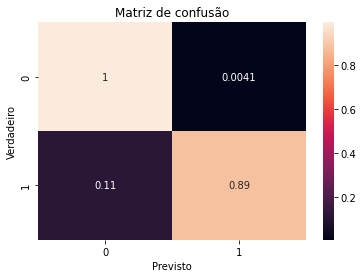

AUC: 0.9413



In [26]:
# Fazer previsões em cima de novos dados
y_pred = final_model.predict(X_test)

# Imprimir relatório de classificação
print(classification_report(y_test , y_pred))

# Plotar matriz de confusão
fig , ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, ax=ax)
ax.set_title("Matriz de confusão")
ax.set_ylabel("Verdadeiro")
ax.set_xlabel("Previsto")
plt.show()

# imprimir a área sob a curva
from sklearn.metrics import roc_auc_score
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

Obtivemos um desempenho similar comparado ao conjunto de treino e validação. Isso é ótimo, pois, mostra que o modelo está confiável ao se expor a novos dados, tecnicamente falando, o modelo não está sofrendo do problema de overfitting.

# Conclusão

Atingimos o resultado desejado pela empresa. A ideia agora é implementar, monitorar e fazer a manutenção do modelo, etapa que não iremos detalhar aqui.

As etapas detalhadas aqui, foram:
* Entendimento do problema de negócio;
* Definir métricas de desempenho;
* Coleta dos dados;
* Análise exploratória;
* Feature Engineering;
* Limpeza e preparação dos dados;
* Selecionar e treinar modelos de machine learning;
* Avaliar o modelo final no conjunto de teste;
* Conclusão.

Obrigado por seguir até aqui!